# Aircraft Envelope

The following formulas are used:

$$
q_c = P_0\left[\left(\frac{\rho_0}{P_0}\frac{V_c^2}{7}+1\right)^{\frac{7}{2}} - 1\right]
$$
---
$$
V_e = \sqrt{7 \frac{P_a}{\rho_0} \left( \left( \frac{q_c}{P_a} + 1 \right)^{\frac{2}{7}} - 1 \right)}
$$
---
$$
\text{Altitudes below 36,089} \\
\delta = (1-k_1H)^{k_2} \\
\sigma = (1-K_1H)^{K_2-1} \\
\theta = (1-K_1H)\\
\text{Where } k_1=\frac{L}{T_0}=6.87559 \times 10^{-6}, k_2=\frac{g_0}{RL}=5.2559, H=\text{ height in ft} \\
\text{Altitudes above 36,089} \\
\delta = 0.223358e^{-k_3(H-36089)} \\
\sigma = 0.29707e^{-k_3(H-36089)} \\
\theta = 0.7519\\
\text{Where } k_3=\frac{g}{RT_a}=4.80614\times 10^{-5}
$$
---
$$
P_a = P_0 \times \delta
$$

$$
V_T = \frac{V_e}{\sqrt{\sigma}}
$$

$$
M=\frac{V_T}{a_0 \sqrt{\theta}}
$$

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# Define Constants US units
# =============================================================================

P_0 = 2116.22 # [lbs/ft^2]
rho_0 = 0.002377 # [slug/ft^3]
a_0 = 661 # [kts]

k1 = 6.87559e-6 # L/T0
k2 = 5.2559 # g0/RL
k3 = 4.80614e-5 # g0/RTa

height_divide = 36089 # [ft]

kt_fps = 1.68781

def get_std_delta(h):
    if h < height_divide:
        return (1 - k1*h)**k2
    else:
        return 0.223358*np.exp(-k3*(h - height_divide))
    
def get_std_sigma(h):
    if h < height_divide:
        return (1 - k1*h)**(k2-1)
    else:
        return 0.29707*np.exp(-k3*(h - height_divide))
    
def get_std_theta(h):
    if h < height_divide:
        return (1 - k1*h)
    else:
        return 0.7519

def kts_to_fps(kts):
    return kts*kt_fps

def fps_to_kts(fps):
    return fps/kt_fps

def calc_qc(vc):
    return P_0*((rho_0/P_0*vc**2/7+1)**(7/2)-1)

def calc_Pa(h):
    return P_0*get_std_delta(h)

def calc_ve(Pa, qc):
    return np.sqrt(7*Pa/rho_0*((qc/Pa+1)**(2/7)-1))

def calc_vt(ve, h):
    return ve/np.sqrt(get_std_sigma(h))

def calc_mach(vt, h):
    return vt/(a_0*np.sqrt(get_std_theta(h)))

In [52]:
def calc_mach_from_vc(vc, h):
    vc_fps = kts_to_fps(vc)
    qc = calc_qc(vc_fps)
    Pa = calc_Pa(h)
    ve_fps = calc_ve(Pa, qc)
    ve = fps_to_kts(ve_fps)
    vt = calc_vt(ve, h)
    return calc_mach(vt, h)

In [53]:
def get_mach(speed_row, altitude):
    if speed_row['Speed Type'] == 'CAS':
        return calc_mach_from_vc(speed_row['Speed Value'], altitude)
    return speed_row['Speed Value']

In [54]:
# =============================================================================
# Read Aircraft Envelope from Excel
# =============================================================================

# Load the Excel file into a DataFrame
envelope_data = pd.read_excel('aircraft_envelope.xlsx')

# Excel Table looks like this:
# | Altitude | Limit Type | Speed Type | Speed Value |
# |----------|------------|------------|-------------|
# | 0        | Min        | CAS        | 123         |
# | 0        | Max        | CAS        | 485         |
# | 5000     | Min        | CAS        | 250         |
# | 9000     | Max        | Mach       | 0.85        |
# | 45000    | Max        | Mach       | 0.85        |

# Sort the data by altitude in ascending order
envelope_data = envelope_data.sort_values(by='Altitude')

# =============================================================================
# Generate Data for Envelope Plot
# =============================================================================
min_speeds = envelope_data[envelope_data['Limit Type'] == 'Min']
max_speeds = envelope_data[envelope_data['Limit Type'] == 'Max']
max_altitude = envelope_data['Altitude'].max()

# altitudes = np.linspace(0, max_altitude, int(max_altitude / 1000) + 1)
altitudes = np.linspace(0, max_altitude, 100)

min_machs = []
max_machs = []

for h in altitudes:
    current_max_speeds = max_speeds[max_speeds['Altitude'] <= h]
    max_speed = current_max_speeds.iloc[-1]
    max_mach = get_mach(max_speed, h)
    max_machs.append(max_mach)

    current_min_speeds = min_speeds[min_speeds['Altitude'] <= h]
    min_speed = current_min_speeds.iloc[-1]
    min_mach = get_mach(min_speed, h)
    if min_mach > max_machs[-1]:
        min_mach = max_machs[-1]
    min_machs.append(min_mach)

altitudes_up_down = np.concatenate((altitudes, altitudes[::-1]))
envelope_machs = np.concatenate((min_machs, max_machs[::-1]))

envelope = pd.DataFrame({
    'Mach': envelope_machs,
    'Altitude': altitudes_up_down
})

In [55]:
# =============================================================================
# Test Envelope (with buffers)
# =============================================================================
te_min_speeds = envelope_data[envelope_data['Limit Type'] == 'Min']
te_max_speeds = envelope_data[envelope_data['Limit Type'] == 'Max']
te_max_altitude = envelope_data['Altitude'].max()

alt_buffer = 2000
speed_buffer = 15
mach_buffer = 0.02

te_altitudes = np.linspace(0, te_max_altitude - alt_buffer, 100)

te_min_machs = []
te_max_machs = []

for h in te_altitudes:
    te_current_max_speeds = te_max_speeds[te_max_speeds['Altitude'] <= h]
    te_max_speed = te_current_max_speeds.iloc[-1]
    if te_max_speed['Speed Type'] == 'CAS':
        mxspeed = te_max_speed['Speed Value']
        mxspeed = mxspeed - speed_buffer
        te_max_machs.append(calc_mach_from_vc(mxspeed, h))
    else:
        mxmach = te_max_speed['Speed Value']
        mxmach = mxmach - mach_buffer
        te_max_machs.append(mxmach)

    te_current_min_speeds = te_min_speeds[te_min_speeds['Altitude'] <= h]
    te_min_speed = te_current_min_speeds.iloc[-1]
    if te_min_speed['Speed Type'] == 'CAS':
        mispeed = te_min_speed['Speed Value']
        mispeed = mispeed + speed_buffer
        mimach = calc_mach_from_vc(mispeed, h)
        if mimach > te_max_machs[-1]:
            mimach = te_max_machs[-1]
        te_min_machs.append(mimach)
    else:
        mimach = te_min_speed['Speed Value']
        mimach = mimach + mach_buffer
        te_min_machs.append(mimach)

te_altitudes_up_down = np.concatenate((te_altitudes, te_altitudes[::-1]))
te_envelope_machs = np.concatenate((te_min_machs, te_max_machs[::-1]))

test_envelope = pd.DataFrame({
    'Mach': te_envelope_machs,
    'Altitude': te_altitudes_up_down
})

In [56]:
# =============================================================================
# EAS graph lines
# =============================================================================
eas100_mach = []
eas200_mach = []
eas300_mach = []
eas400_mach = []

max_mach = envelope.Mach.max()

for h in altitudes:
    eas100_mach.append(calc_mach_from_vc(100, h))
    eas200_mach.append(calc_mach_from_vc(200, h))
    eas300_mach.append(calc_mach_from_vc(300, h))
    eas400_mach.append(calc_mach_from_vc(400, h))

# Remove machs greater than 0.85
eas100_mach = np.minimum(eas100_mach, max_mach)
eas200_mach = np.minimum(eas200_mach, max_mach)
eas300_mach = np.minimum(eas300_mach, max_mach)
eas400_mach = np.minimum(eas400_mach, max_mach)



In [57]:
test_ranges = pd.read_excel('test_points.xlsx', sheet_name='Ranges')
# test_ranges["From Speed Type"]
test_ranges['From Mach'] = test_ranges.apply(
    lambda row: row['From Speed Value'] if row['From Speed Type'] == 'Mach' else calc_mach_from_vc(row['From Speed Value'], row['From Altitude [ft]']),
    axis=1
)
test_ranges
test_ranges['To Mach'] = test_ranges.apply(
    lambda row: row['To Speed Value'] if row['To Speed Type'] == 'Mach' else calc_mach_from_vc(row['To Speed Value'], row['To Altitude [ft]']),
    axis=1
)

In [58]:
# =============================================================================
# Test Points
# =============================================================================

test_points = pd.read_excel('test_points.xlsx', sheet_name='Points')

test_points['Mach'] = test_points.apply(
    lambda row: row['Speed Value'] if row['Speed Type'] == 'Mach' else get_mach(row, row['Altitude [ft]']),
    axis=1
)

In [59]:
transitions = pd.DataFrame({
    "Speed Value": [95, 148, 135, 0.8, 205],
    "Speed Type": ["CAS", "CAS", "CAS", "Mach", "CAS"],
    "Altitude [ft]": [0, 15000, 20000, 20000, 25000]
})

transitions['Mach'] = transitions.apply(
    lambda row: row['Speed Value'] if row['Speed Type'] == 'Mach' else get_mach(row, row['Altitude [ft]']),
    axis=1
)

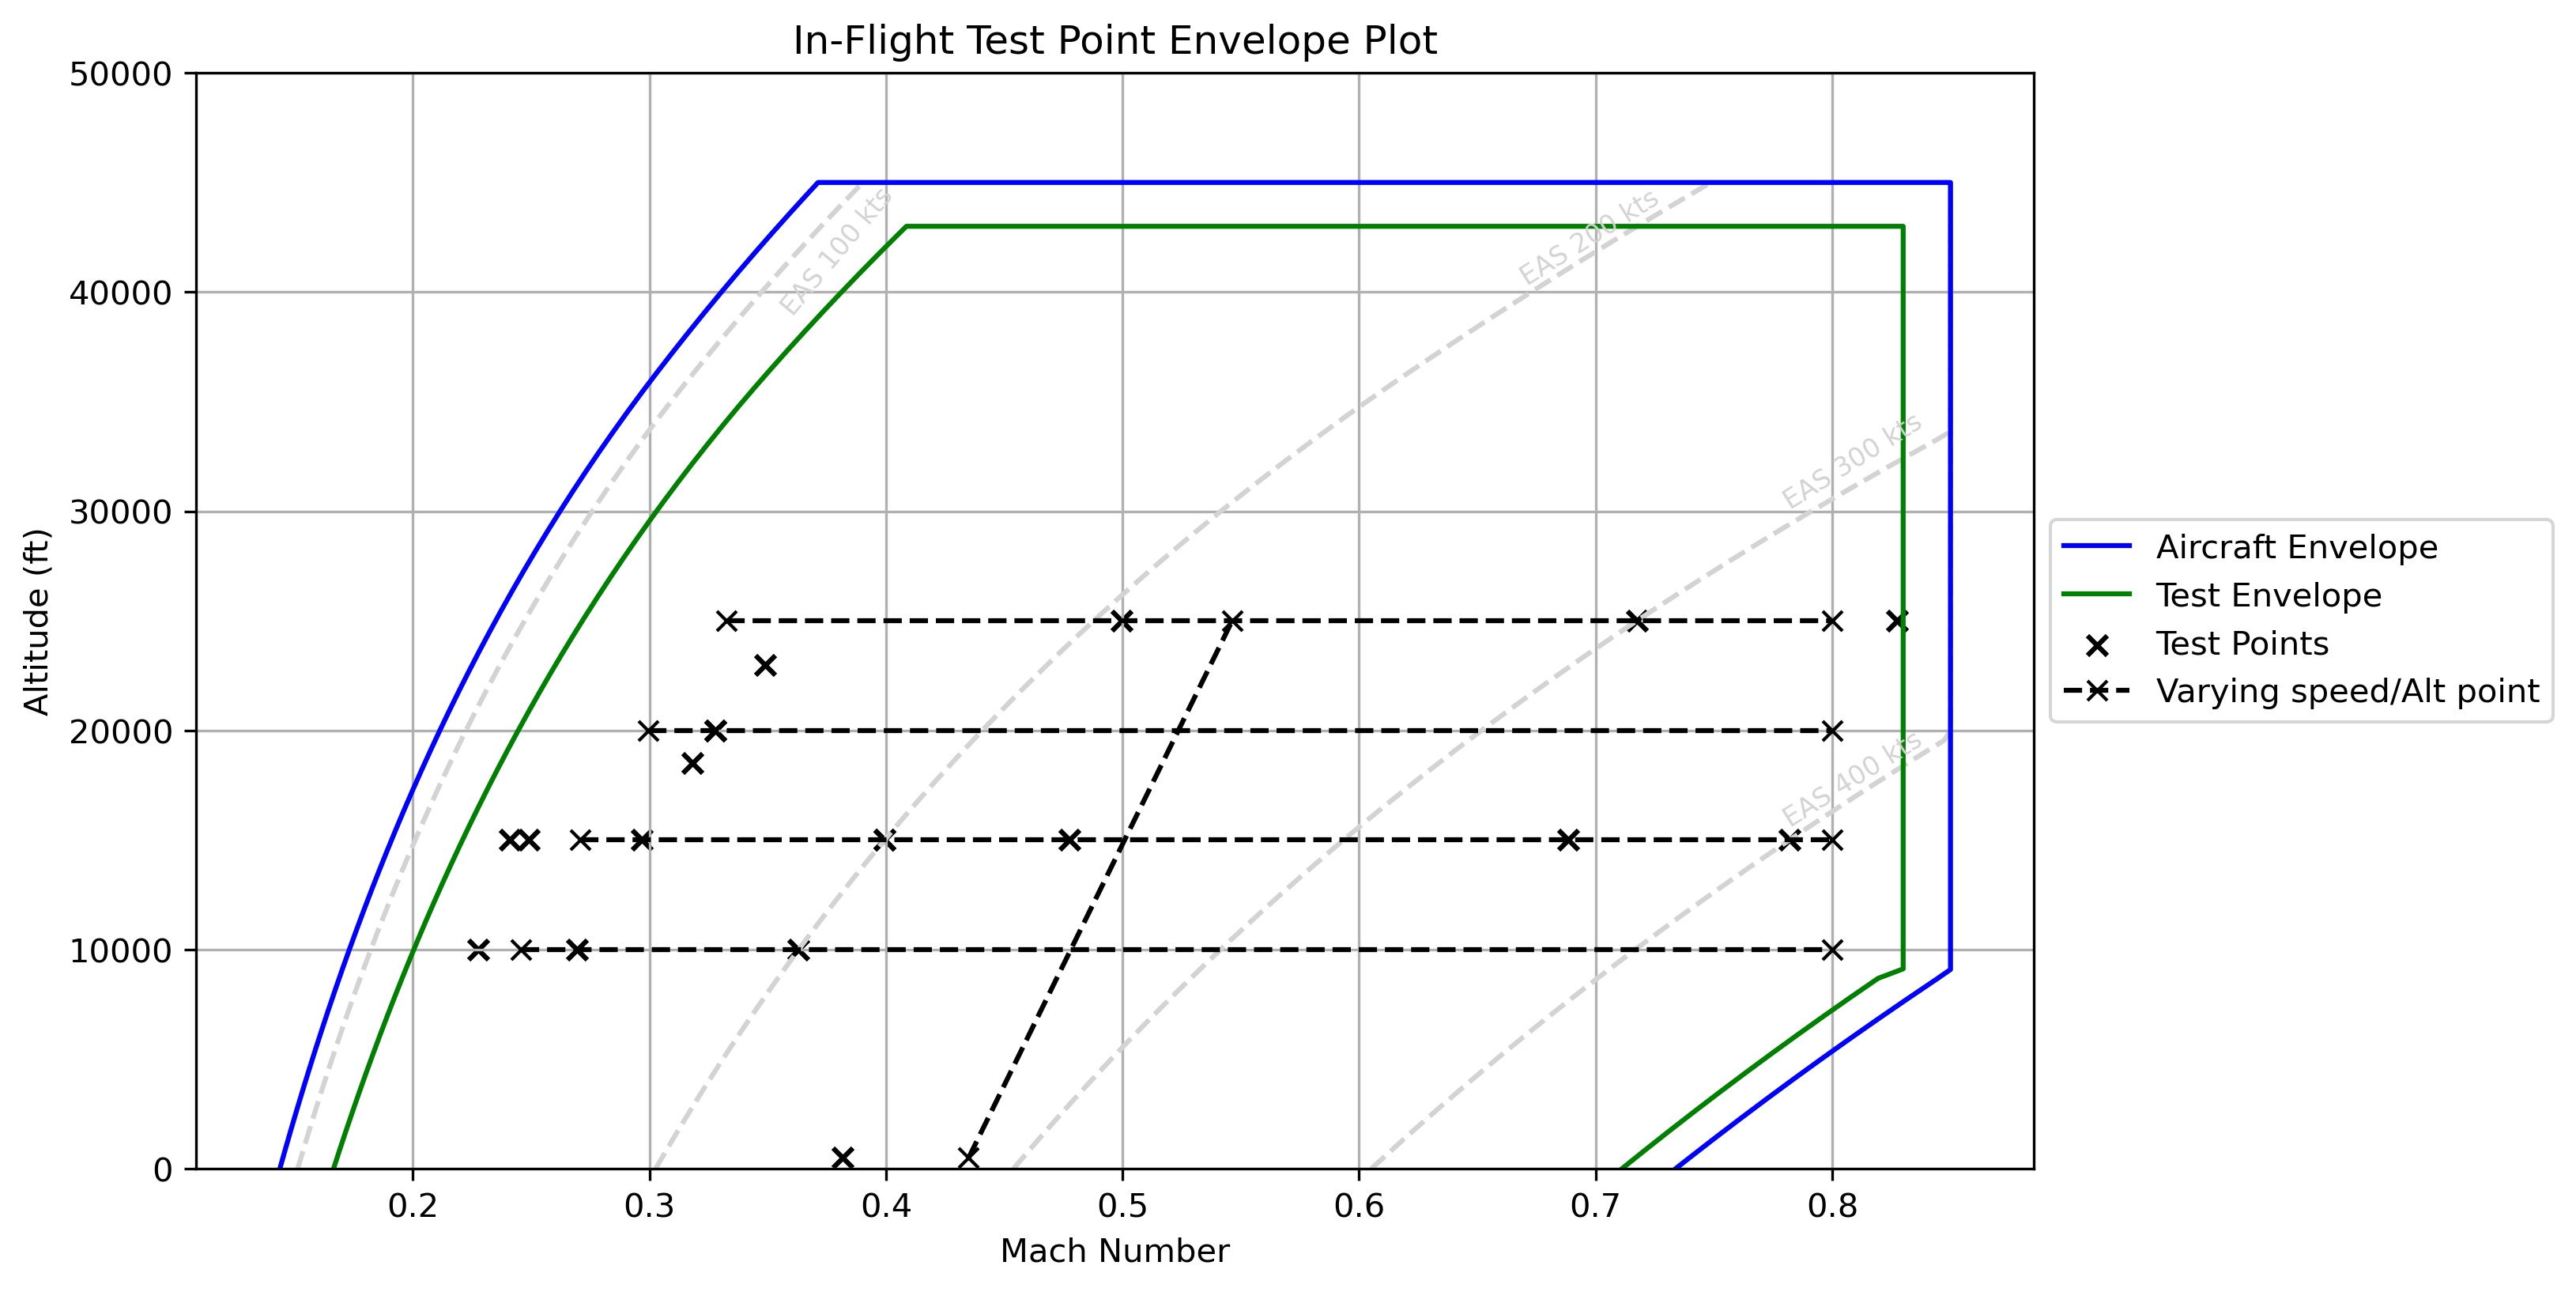

In [60]:
# =============================================================================
# Plotting
# =============================================================================

plt.figure(figsize=(10, 6), dpi=300)
plt.style.use('default')

plt.plot(eas100_mach, altitudes, color="lightgray", linestyle='--')
plt.plot(eas200_mach, altitudes, color="lightgray", linestyle='--')
plt.plot(eas300_mach, altitudes, color="lightgray", linestyle='--')
plt.plot(eas400_mach, altitudes, color="lightgray", linestyle='--')

# annotate the EAS lines
plt.text(eas100_mach[-1] + 0.015, altitudes[-1], "EAS 100 kts", rotation=50, horizontalalignment='right', verticalalignment='top', fontsize=8, color='lightgray')
plt.text(eas200_mach[-1] - 0.02, altitudes[-1]-100, "EAS 200 kts", rotation=32, horizontalalignment='right', verticalalignment='top', fontsize=8, color='lightgray')
plt.text(eas300_mach[-1] - 0.01, 34700, "EAS 300 kts", rotation=32, horizontalalignment='right', verticalalignment='top', fontsize=8, color='lightgray')
plt.text(eas400_mach[-1] - 0.01, 20200, "EAS 400 kts", rotation=32, horizontalalignment='right', verticalalignment='top', fontsize=8, color='lightgray')

plt.plot(envelope['Mach'], envelope['Altitude'], label="Aircraft Envelope", color="blue")
plt.plot(test_envelope['Mach'], test_envelope['Altitude'], label="Test Envelope", color="green")
# plt.fill_betweenx(test_envelope['Altitude'], test_envelope['Mach'], envelope['Mach'], color="red", alpha=0.2)
# plt.fill_between(envelope['Mach'], test_envelope['Altitude'], envelope['Altitude'], color="red", alpha=0.2)
# =============================================================================
# Uncomment this block to plot test points with different markers and colors
# =============================================================================
# # Define a dictionary of markers and colors for each unique test point
# marker_styles = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']  # Add more if needed
# color_styles = ['g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']  # Add more if needed

# # Get unique test point types
# unique_test_points = test_points['Test Point'].unique()

# # Create a dictionary to map each test point type to a marker and color
# style_mapping = {test_point: (marker_styles[i % len(marker_styles)], color_styles[i % len(color_styles)])
# for i, test_point in enumerate(unique_test_points)}

# # Plot each test point type with its corresponding style
# for test_point, (marker, color) in style_mapping.items():
#     subset = test_points[test_points['Test Point'] == test_point]
#     plt.scatter(subset['Mach'], subset['Altitude [ft]'], label=test_point, marker=marker, color=color)
# =============================================================================


plt.scatter(test_points['Mach'], test_points['Altitude [ft]'], label="Test Points", marker='x', color='black')

# Plot varying test points
first_entry = True
for index, row in test_ranges.iterrows():
    if first_entry:
        plt.plot([row['From Mach'], row['To Mach']],
                 [row['From Altitude [ft]'], row['To Altitude [ft]']],
                 marker='x', color="black", linestyle='--', label="Varying speed/Alt point")
        first_entry = False
    else:
        plt.plot([row['From Mach'], row['To Mach']],
                 [row['From Altitude [ft]'], row['To Altitude [ft]']],
                 marker='x', color="black", linestyle='--')

# Plot transitions
# plt.plot(transitions['Mach'], transitions['Altitude [ft]'], label="Transitions", color='red')

plt.xlabel("Mach Number")
plt.ylabel("Altitude (ft)")
plt.title("In-Flight Test Point Envelope Plot")
plt.grid()
plt.ylim(0, max_altitude+5000)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('./plots/test_point_envelope_plot.png', dpi=300, bbox_inches='tight')
plt.show()